In [126]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from plot import get_cohort_careerage_df

In [2]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-1-year.csv')
authorStartEndCareerData.head()

,author,start_year,end_year,num_pub,career_length,max_absence,avg_absence,dropped_after_10,gender
0,'maseka lesaoana,2001,2015,2,15,14,14.0,True,none
1,(max) zong-ming cheng,2009,2011,2,3,2,2.0,False,none
2,(zhou) bryan bai,2011,2012,2,2,1,1.0,False,none
3,a aart blokhuis,1992,2005,2,14,13,13.0,True,none
4,a ahrabian,2017,2017,1,1,15,15.0,True,none


In [110]:
END_YEAR = 2018
MAX_CAREER_LENGTH_COHORT = 15

years = authorStartEndCareerData['start_year'].unique()
years = sorted(years)
cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]

In [111]:
average_absence_cohort = authorStartEndCareerData.groupby('start_year')['avg_absence'].mean()

In [118]:
average_absence_cohort = average_absence_cohort.loc[cohort_start_years]

## Average waiting time analysis over cohorts

In [121]:
## We expect to see that average waiting times are decreasing over time since scientists recently form larger collaborations

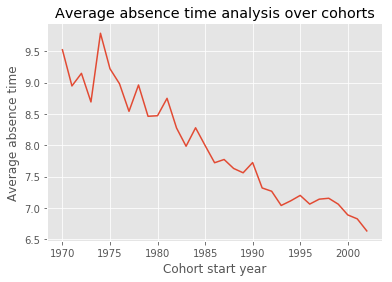

In [124]:
x = average_absence_cohort.index
y = average_absence_cohort.values
plt.plot(x,y)
plt.title("Average absence time analysis over cohorts")
plt.xlabel('Cohort start year')
plt.ylabel("Average absence time")
plt.show()

In [143]:
# unique_career_ages = np.unique(data["age"])
# max_years = np.max(unique_career_ages)
# cols = 5   
# nrows = int(math.ceil(float(max_years)/float(cols)))

In [144]:
# fig2, ax2 = plt.subplots(nrows=nrows, ncols=cols, sharex=True, sharey=True, figsize=(16,10))

In [145]:
# p = get_cohort_careerage_df(cohort_start_years, 15, 'avg_absence', authorStartEndCareerData)

## Dropouts

In [163]:
inactive = authorStartEndCareerData.groupby(['start_year', 'gender'])['dropped_after_10'].sum()

In [164]:
total = authorStartEndCareerData.groupby(['start_year', 'gender'])['dropped_after_10'].count()

In [165]:
inactive = inactive.to_frame()
inactive['all'] = total

In [177]:
inactive.head()

,start_year,gender,dropped_after_10,all,percent_dropped
0,1970,f,23.0,35,65.714286
1,1970,m,246.0,416,59.134615
2,1970,none,180.0,312,57.692308
3,1971,f,39.0,61,63.934426
4,1971,m,275.0,529,51.984877


In [167]:
inactive['percent_dropped'] = (inactive['dropped_after_10']*100)/inactive['all']

In [168]:
inactive = inactive.loc[cohort_start_years]

In [169]:
inactive.reset_index(inplace=True)

In [170]:
data_m = inactive[inactive['gender']=='m']
data_f = inactive[inactive['gender']=='f']
data_n = inactive[inactive['gender']=='none']

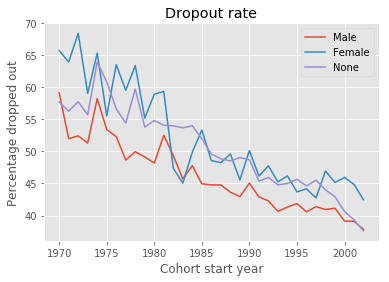

In [174]:
plt.plot(data_m['start_year'], data_m['percent_dropped'], label='Male')
plt.plot(data_f['start_year'], data_f['percent_dropped'], label='Female')
plt.plot(data_n['start_year'], data_n['percent_dropped'], label='None')
plt.title("Dropout rate")
plt.ylabel('Percentage dropped out')
plt.xlabel('Cohort start year')
plt.legend()
plt.show()

## Cliffs delta analysis

In [3]:
male = authorStartEndCareerData[authorStartEndCareerData.gender == 'm'].max_absence

In [4]:
female = authorStartEndCareerData[authorStartEndCareerData.gender == 'f'].max_absence

In [5]:
print(male.shape)
print(female.shape)

(793766,)
(255500,)


In [34]:
def cliffsD(ser1, ser2):
    # only small integer values!
    np_1 = np.array(ser1, dtype=np.int8)
    np_2 = np.array(ser2, dtype=np.int8)
    return np.mean(np.sign(np_1[:, None] - np_2).mean(axis=1))

In [33]:
# over whole dataset
cliffsD(male, female)
# -0.056557295548457606

-0.056557295548457606

In [74]:
def cliffs_delta_cohorts(data, column, val1, val2, criterion, years):
    cliffsD_lst = []
    for start_year in years:
        data1 = data[data.start_year == start_year]
        cliffsd = cliffsD(data1[data1[column] == val1][criterion], data1[data1[column] == val2][criterion])
        cliffsD_lst.append([start_year, cliffsd])
    cliffsD_cohorts = pd.DataFrame(columns=['start_year', 'cliffsD'], data=cliffsD_lst)
    return cliffsD_cohorts

In [137]:
def plot_cliffs_delta(cliffsD_cohorts, p1, p2, p3):
    x = cliffsD_cohorts['start_year']
    y = cliffsD_cohorts['cliffsD']
    plt.scatter(x, y)
    fit = np.polyfit(x, y, deg=1)
    plt.plot(x, fit[0] * x + fit[1], color='C1')
    plt.plot(x, [0]*len(x), color='C2')
    plt.title("Cliff's Delta for "+p1+" and "+p2+" for "+p3)
    plt.xlabel('Cohort start year')
    plt.ylabel("Cliff's Delta")
    plt.show()

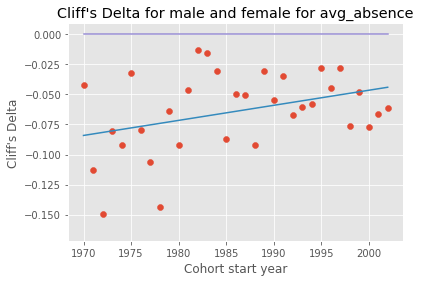

In [138]:
cd11 = cliffs_delta_cohorts(authorStartEndCareerData, 'gender', 'm', 'f', 'avg_absence', cohort_start_years)
plot_cliffs_delta(cd11, 'male', 'female', 'avg_absence')

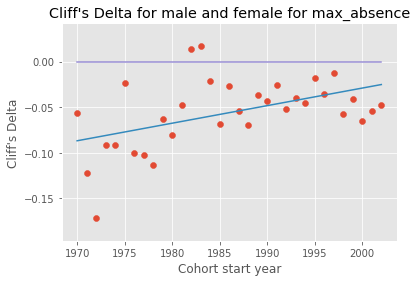

In [139]:
cd1 = cliffs_delta_cohorts(authorStartEndCareerData, 'gender', 'm', 'f', 'max_absence', cohort_start_years)
plot_cliffs_delta(cd1, 'male', 'female', 'max_absence')

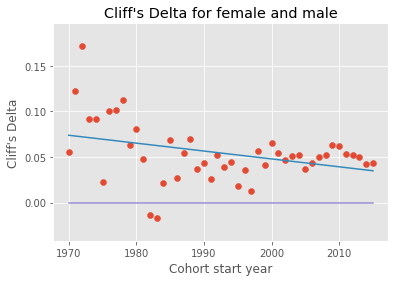

In [105]:
cd2 = cliffs_delta_cohorts(authorStartEndCareerData, 'gender', 'f', 'm', 'max_absence', cohort_start_years)
plot_cliffs_delta(cd2, 'female', 'male')

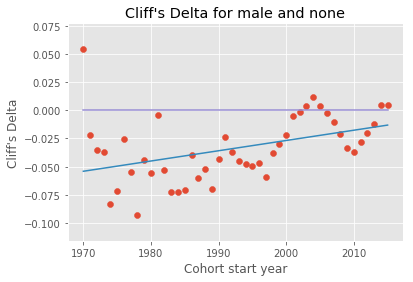

In [106]:
cd3 = cliffs_delta_cohorts(authorStartEndCareerData, 'gender', 'm', 'none', 'max_absence', cohort_start_years)
plot_cliffs_delta(cd3, 'male', 'none', 'max_absence')

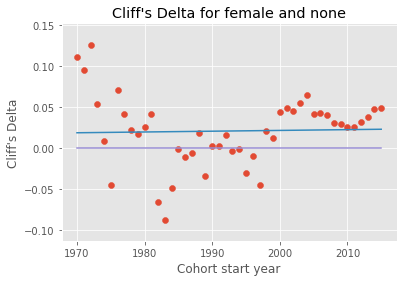

In [107]:
cd4 = cliffs_delta_cohorts(authorStartEndCareerData, 'gender', 'f', 'none', 'max_absence', cohort_start_years)
plot_cliffs_delta(cd4, 'female', 'none', 'max_absence')